In [1]:
import datetime
import json
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import numpy
from functools import reduce
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import statsmodels.tsa.stattools as ts

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Setup and Cleaning

In [3]:
files = os.listdir("data/")
symbols = [f[:-4] for f in files if f[-4:]==".csv"]
print(symbols)
dfs = {f[:-4]: pd.read_csv("data/" + f, index_col="time") for f in files if f[-4:]==".csv"}

['ZECETH', 'TRXETH', 'XRPETH', 'BNBBTC', 'EOSETH', 'LTCBNB', 'DASHBNB', 'XMRBNB', 'DASHUSDT', 'TRXBNB', 'ZECBNB', 'ADABTC', 'ZECUSDT', 'EOSBNB', 'LTCETH', 'XRPBNB', 'XMRETH', 'BNBUSDT', 'DASHETH', 'LTCUSDT', 'ETHBTC', 'TRXUSDT', 'TRXXRP', 'TRXBTC', 'ZECBTC', 'ADABNB', 'ETHUSDT', 'BTCUSDT', 'XMRUSDT', 'EOSBTC', 'BNBETH', 'XRPBTC', 'DASHBTC', 'EOSUSDT', 'XMRBTC', 'ADAETH', 'ADAUSDT', 'XRPUSDT', 'LTCBTC']


In [4]:
n = 30000
good_dfs = {}
for k, v in dfs.items():
    if v.shape[0] > n:
        good_dfs[k] = v

In [5]:
for k, v in good_dfs.items():
    good_dfs[k].index = pd.to_datetime(good_dfs[k].index, unit="ms", utc=True)

closes_ls = [good_dfs[k]['close'] for k, v in good_dfs.items()]
closes_df = pd.concat(closes_ls, axis=1).dropna()
closes_df.columns = list(good_dfs.keys())
closes_df.shape

(32687, 31)

In [6]:
bad_times = list(pd.DataFrame(closes_df.index).time.diff().unique())
[i.astype('timedelta64[m]') for i in bad_times] 

[numpy.timedelta64('NaT','m'),
 numpy.timedelta64(15,'m'),
 numpy.timedelta64(615,'m'),
 numpy.timedelta64(120,'m'),
 numpy.timedelta64(465,'m'),
 numpy.timedelta64(225,'m'),
 numpy.timedelta64(435,'m'),
 numpy.timedelta64(375,'m')]

In [7]:
closes_df = closes_df.resample('15T').max()
closes_df.fillna(method="ffill", inplace=True)
closes_df.shape # The dimensions have changed!

(32870, 31)

In [8]:
dfs_keys = good_dfs.keys()
usd_pairs = list(filter(lambda x:  x[-4:] == 'USDT', list(dfs_keys)))
btc_pairs = list(filter(lambda x:  x[-3:] == 'BTC', list(dfs_keys)))
eth_pairs = list(filter(lambda x:  x[-3:] == 'ETH', list(dfs_keys)))
bnb_pairs = list(filter(lambda x:  x[-3:] == 'BNB', list(dfs_keys)))
pairs = {'USD': usd_pairs, 'BTC': btc_pairs, 'ETH': eth_pairs, 'BNB': bnb_pairs}

In [9]:
close_prices = closes_df[pairs['USD']]
# close_prices = closes_df

In [10]:
log_prices = FunctionTransformer(func=numpy.log).fit_transform(close_prices)
returns = pd.DataFrame(log_prices).diff()
returns.columns = close_prices.columns
returns = returns.drop(returns.index[0])
returns.corr()

,BNBUSDT,LTCUSDT,TRXUSDT,ETHUSDT,BTCUSDT,EOSUSDT,ADAUSDT,XRPUSDT
BNBUSDT,1.000000,0.496561,0.490588,0.554598,0.551974,0.507958,0.514062,0.444468
LTCUSDT,0.496561,1.000000,0.606620,0.765425,0.739385,0.724486,0.668983,0.586141
TRXUSDT,0.490588,0.606620,1.000000,0.675607,0.675920,0.632102,0.671486,0.581334
ETHUSDT,0.554598,0.765425,0.675607,1.000000,0.792550,0.763085,0.736680,0.653302
BTCUSDT,0.551974,0.739385,0.675920,0.792550,1.000000,0.738121,0.732192,0.634479
EOSUSDT,0.507958,0.724486,0.632102,0.763085,0.738121,1.000000,0.687285,0.609630
ADAUSDT,0.514062,0.668983,0.671486,0.736680,0.732192,0.687285,1.000000,0.635516
XRPUSDT,0.444468,0.586141,0.581334,0.653302,0.634479,0.609630,0.635516,1.000000


## Cointegration

In [11]:
log_df = pd.DataFrame(log_prices)
log_df.index = close_prices.index
log_df.columns = usd_pairs

n = log_df.shape[0]
m = 100

def get_cointegration(asset_1, asset_2):
    cointegrations = []

    for i in range(0, (n-m)):
        roll_df = log_df.iloc[i:(i+m), :]
        btc = roll_df[asset_1]
        eth = roll_df[asset_2]
        cointegrations.append(ts.coint(btc, eth)[1])
    
    return cointegrations

In [12]:
class RollingAnalyzer:
    
    def __init__(self, prices, m):
        self.prices = prices
        self.returns = pd.DataFrame(prices).diff()
        self.n = prices.shape[0]
        self.m = m
        self.rolled_dfs = None
        self.regressions = {}
        self.pairs = []
    
    def make_dfs(self):
        roll_range = range(0, self.n - self.m)
        self.rolled_dfs = [pd.DataFrame(self.prices.iloc[i:(i+self.m), :]) for i in roll_range]
    
    def run_regressions(self, asset_1, asset_2):
        code = asset_1 + '_' + asset_2
        self.regressions[code] = []
        for df in self.rolled_dfs:
            date_range = df.index[0], df.index[df.shape[0]-1]
            x = df[asset_1].values.reshape(-1, 1)
            y = df[asset_2].values
            linear_regression = LinearRegression().fit(x, y)
            residuals = y - linear_regression.predict(x)
            reg_dict = {
                'date_range': date_range,
                'regression': linear_regression,
                'residuals': residuals,
            }
            self.regressions[code].append(reg_dict)
        
    def asset_loop(self):
        for i in range(0, self.prices.shape[1]):
            pair_i = self.prices.columns[i]
            for j in range(0, i):
                pair_j = self.prices.columns[j]
                if pair_i != pair_j:
                    self.pairs.append((pair_i, pair_j))
    
    def run_all_regressions(self):
        if not self.pairs:
            print("Must make pairs")
        else:
            for pair in self.pairs:
                self.run_regressions(pair_i, pair_j)
    
    def calc_dickey_fuller(self, asset_1, asset_2):
        code = asset_1 + '_' + asset_2
        if code not in self.regressions.keys():
            print('Assets not regressed yet')
        else:
            for regression in self.regressions[code]:
                regression['dickey_fuller'] = ts.adfuller(regression['residuals'])
                
    def calc_all_dickey_fullers(self):
        if not self.pairs:
            print("Must make pairs")
        else:
            for pair in self.pairs:
                self.calc_dickey_fuller(pair_i, pair_j)        
                
    def export_df(self):
        dickey_fullers = {}
        date_index = []
        for k, v in self.regressions.items():
            dickey_fullers[k] = v['dickey_fuller']
            date_index.append(v['date_range'][0])
        out_df = pd.from_dict(dickey_fuller)
        out_df.index = date_index
        return(out_df)

In [13]:


if os.path.isfile("cointegration.json"):
    with open("cointegration.json", "r") as f:
        cointegration_mv = json.load(f)
else:
    cointegration_mv = {}
    for i in range(0, len(usd_pairs)):
        pair_i = usd_pairs[i]
        print(pair_i)
        for j in range(0, i):
            pair_j = usd_pairs[j]
            print("\t+",pair_j)
            if pair_i != pair_j:
                code = pair_i + '_' + pair_j
                print("\t\t=",code)
                cointegration_mv[code] = get_cointegration(pair_i, pair_j)
    
    json = json.dumps(cointegration_mv)
    f = open("cointegration.json","w")
    f.write(json)
    f.close()

In [14]:
cointegration_mv.keys()

dict_keys(['ETHUSDT_BNBUSDT', 'LTCUSDT_XRPUSDT', 'BTCUSDT_TRXUSDT', 'XRPUSDT_EOSUSDT', 'XRPUSDT_ADAUSDT', 'LTCUSDT_EOSUSDT', 'ADAUSDT_BNBUSDT', 'LTCUSDT_BNBUSDT', 'BTCUSDT_ADAUSDT', 'BNBUSDT_EOSUSDT', 'BTCUSDT_EOSUSDT', 'TRXUSDT_BNBUSDT', 'ETHUSDT_ADAUSDT', 'BTCUSDT_ETHUSDT', 'BTCUSDT_BNBUSDT', 'ETHUSDT_TRXUSDT', 'BTCUSDT_XRPUSDT', 'TRXUSDT_ADAUSDT', 'XRPUSDT_TRXUSDT', 'XRPUSDT_BNBUSDT', 'ETHUSDT_XRPUSDT', 'ADAUSDT_EOSUSDT', 'ETHUSDT_LTCUSDT', 'LTCUSDT_ADAUSDT', 'ETHUSDT_EOSUSDT', 'TRXUSDT_EOSUSDT', 'BTCUSDT_LTCUSDT', 'LTCUSDT_TRXUSDT'])

In [15]:
from scipy.stats import norm

coint_df = pd.DataFrame.from_dict(cointegration_mv)
coint_df.index = log_df.index[m:]

def to_good_range(col):
    return norm.ppf(col, loc=0, scale=1)

coint_inf_df = coint_df.apply(to_good_range)

## Create Test / Train Data

In [16]:
subset = coint_df.iloc[:2000, :]
target_label = 'BTCUSDT_ETHUSDT'

# default lookback is 1 day = 15min intervals * 96 obversavtions
# default lookforward is 2 hours = 15min intervals * 8 obvservations
def ts_split(ts, target_label, feature_steps=100, target_steps=100):
    n_obs = len(ts) - feature_steps - target_steps + 1
        
    X = [ts[idx:idx + feature_steps].as_matrix() for idx in range(n_obs)]
    y = [ts[target_label][idx + feature_steps:idx + feature_steps + target_steps] for idx in range(n_obs)]
    
    return np.array(X), np.array(y)

X, y = ts_split(subset, target_label)
test_train_split = int(0.8 * len(X))
val_train_split = int(0.8 * test_train_split)

X_test, y_test = X[test_train_split:], y[test_train_split:]
X_train, y_train = X[:val_train_split], y[:val_train_split]
X_valid, y_valid = X[val_train_split:test_train_split], y[val_train_split:test_train_split]

(0, 500)

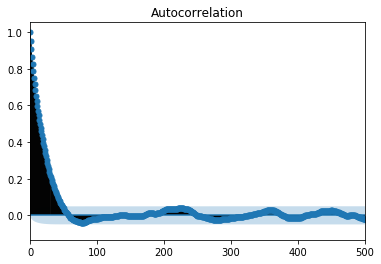

In [70]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(coint_df[target_label])
plt.xlim(0, 500)

## Machine Learning

In [18]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
trax1, trax2, trax3 = X_train.shape
vax1, vax2, vax3 = X_valid.shape
tax1, tax2, tax3 = X_test.shape
d2_X_train = X_train.reshape(trax1, trax2*trax3)
d2_X_valid = X_valid.reshape(vax1, vax2*vax3)
d2_X_test = X_test.reshape(tax1, tax2*tax3)

In [19]:
rfr.fit(d2_X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [20]:
from sklearn.metrics import mean_squared_error

y_pred_train = rfr.predict(d2_X_train)
np.sqrt(mean_squared_error(y_pred_train, y_train))


0.0529932520529715

As we can see, the RMSE decreased using the optimized model. Now I will calculate RMSE on the validation set and create some plots illustrating model performance.

done
done
done
done
done
done


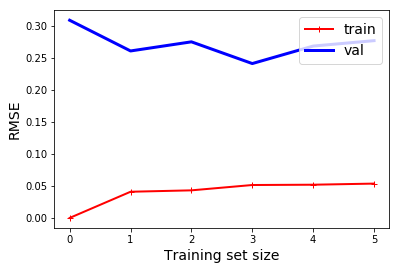

In [23]:
import matplotlib as mlp
import matplotlib.pyplot as plt
ranger = np.arange(1, len(X_train), 200)
def plot_learning_curves(model, X_train, y_train, X_val, y_val):
    train_errors, val_errors = [], []
    for m in ranger:
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        print('done')

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14) 
    plt.xlim = (1, len(d2_X_train))
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14) 
    
plot_learning_curves(rfr, d2_X_train, y_train, d2_X_valid, y_valid)


As you can see, the model is overfitting the data fairly severely. I will attempt to remedy this.

In [24]:
y_pred_val_org = rfr.predict(d2_X_valid)
print(np.sqrt(mean_squared_error(y_pred_val_org, y_valid)))


0.27676870970724426


In [25]:
y_pred_test_rfr = rfr.predict(d2_X_test)

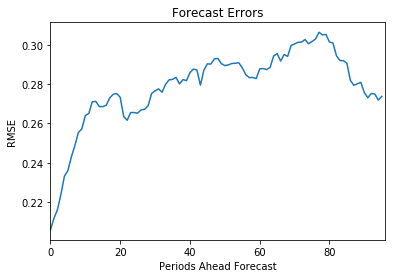

In [26]:
mse_test_rfr = mean_squared_error(y_pred_test_rfr, y_test, multioutput = 'raw_values')
rmse_test_rfr = [np.sqrt(x) for x in mse_test_rfr]
plt.plot(rmse_test_rfr)
plt.title('Forecast Errors')
plt.xlim(0, 100)
plt.ylabel("RMSE")
plt.xlabel("Periods Ahead Forecast")
plt.show()

Let's try the multi-ouptut regressor class and see how well it fits.

In [61]:
from sklearn.multioutput import MultiOutputRegressor

mor = MultiOutputRegressor(rfr, n_jobs = 2)
mor.fit(d2_X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
           n_jobs=2)

done
done
done
done
done
done


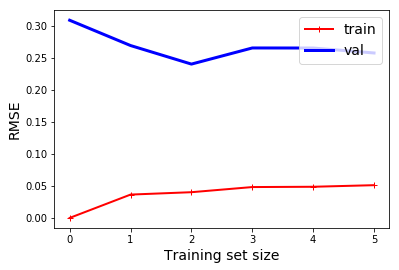

In [29]:
plot_learning_curves(mor, d2_X_train, y_train, d2_X_valid, y_valid)

In [62]:
y_train_pred_mor = mor.predict(d2_X_train)
y_valid_pred_mor = mor.predict(d2_X_valid)
print("The RMSE of the multi-output regressor model on the training set is: ", np.sqrt(mean_squared_error(y_train_pred_mor, y_train)), '\n')

print("The RMSE of the multi-output regressor model on the validation set is: ", np.sqrt(mean_squared_error(y_valid_pred_mor, y_valid)), '\n')

The RMSE of the multi-output regressor model on the training set is:  0.05119676044496937 

The RMSE of the multi-output regressor model on the validation set is:  0.24285258080397498 



The overfitting looks better, but still not very good. The model also fits better. Let's try dimensionality reduction and see if that gives us a model that fits both sets better.

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components = .95, whiten = True)
d2_X_train_pca = pca.fit_transform(d2_X_train, y_train)
d2_X_valid_pca = pca.transform(d2_X_valid)
d2_X_test_pca = pca.transform(d2_X_test)


In [48]:
print(d2_X_train_pca)

[[ 1.01991188 -0.69563529  0.11790277 ... -0.05987418 -0.49981616
   1.24682663]
 [ 1.07768259 -0.68744832  0.08216532 ...  0.21521483 -0.05786412
   0.74280194]
 [ 1.13215165 -0.67968777  0.05305626 ...  0.29398238  0.64492883
   0.14095759]
 ...
 [-1.49527753 -1.91540578  0.64102206 ... -2.23814394 -0.13602316
  -0.68268815]
 [-1.45564147 -1.9074261   0.68616112 ... -2.61849359 -0.26662027
  -0.83377203]
 [-1.41269942 -1.89700984  0.7246205  ... -2.54454098 -0.28917472
  -0.83851649]]


In [49]:
mor_pca = MultiOutputRegressor(rfr, n_jobs = 2)
mor_pca.fit(d2_X_train_pca, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
           n_jobs=2)

done
done
done
done
done
done


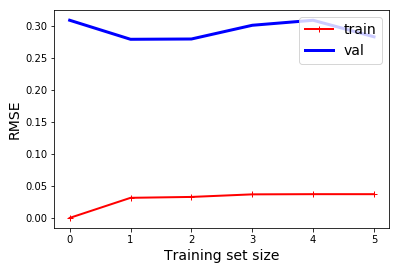

In [50]:
plot_learning_curves(mor_pca, d2_X_train_pca, y_train, d2_X_valid_pca, y_valid)

It appears the model is still overfitting, and is overfitting even worse than before. Let's check RMSE on the validation and training set just to be sure.

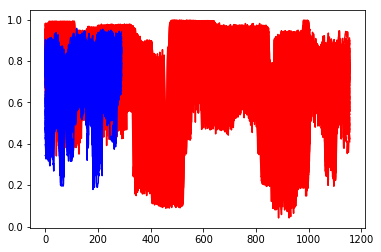

In [53]:
y_pred_train_mor_pca = mor_pca.predict(d2_X_train_pca)
mse_train_mor_pca = mean_squared_error(y_pred_train_mor_pca, y_train, multioutput = 'raw_values')
rmse_train_more_pca = [np.sqrt(x) for x in y_pred_train_mor_pca]
y_pred_valid_mor_pca = mor_pca.predict(d2_X_valid_pca)
mse_train_mor_pca = mean_squared_error(y_pred_valid_mor_pca, y_valid, multioutput = 'raw_values')
rmse_valid_more_pca = [np.sqrt(x) for x in y_pred_valid_mor_pca]
plt.plot(rmse_train_more_pca, 'r', rmse_valid_more_pca, 'b')
plt.show()

Based on this plot it seems the RMSE's are close to one another. However, I would estimate that the final RMSE values will differ more significantly

In [55]:
print("Training set RMSE:\n")
print(np.sqrt(mean_squared_error(y_pred_train_mor_pca, y_train)), "\n")
print("Validation set RMSE:\n")
print(np.sqrt(mean_squared_error(y_pred_valid_mor_pca, y_valid)))

Training set RMSE:

0.13476672962301728 

Validation set RMSE:

0.2827446593534335


While the model does seem to be overfitting less, it is still overfitting. In addition to this, the predicting power of the model has decreased in both training and validation sets. Let's try fine tuning our model parameters to fit noise less frequently.

In [64]:
rfr_tuning = RandomForestRegressor(n_estimators = 50, criterion = 'mse', min_samples_split = 50, min_samples_leaf = 50)
mod_tuned = MultiOutputRegressor(rfr_tuning, n_jobs = 2)
mod_tuned.fit(d2_X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=50, min_samples_split=50,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
           n_jobs=2)

done
done
done
done
done
done


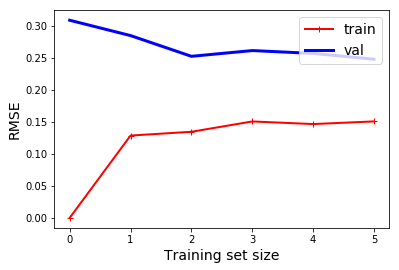

In [65]:
plot_learning_curves(mod_tuned, d2_X_train, y_train, d2_X_valid, y_valid)

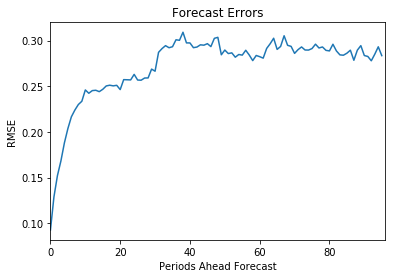

In [68]:
y_pred_test_mod_tuned = mod_tuned.predict(d2_X_test)
mse_test_mod_tuned = mean_squared_error(y_pred_test_mod_tuned, y_test, multioutput = 'raw_values')
rmse_test_mod_tuned = [np.sqrt(x) for x in mse_test_mod_tuned]
plt.plot(rmse_test_mod_tuned)
plt.title('Forecast Errors')
plt.xlim(0, 100)
plt.ylabel("RMSE")
plt.xlabel("Periods Ahead Forecast")
plt.show()

In [69]:
y_pred_train_mod_tuned = mod_tuned.predict(d2_X_train)
y_pred_valid_mod_tuned = mod_tuned.predict(d2_X_valid)
print("The RMSE of the tuned model on the training set is ", np.sqrt(mean_squared_error(y_pred_train_mod_tuned, y_train)), "\n")
print("The RMSE of the tuned model on the validation set is ", np.sqrt(mean_squared_error(y_pred_valid_mod_tuned, y_valid)), "\n")




The RMSE of the tuned model on the training set is  0.17533876992848402 

The RMSE of the tuned model on the validation set is  0.24778269487099253 

The RMSE of the tuned model on the test set is  0.27389744171804653 



The best model appears to be the untuned MultiOutput Regressor model. Let's see how it performs on the test set. It is also important to note that the tuned model fits significantly better than the untuned model, despite only a small drop in performance.

The RMSE of the MultiOutput Regressor model on the test set is:  0.28739721718074646


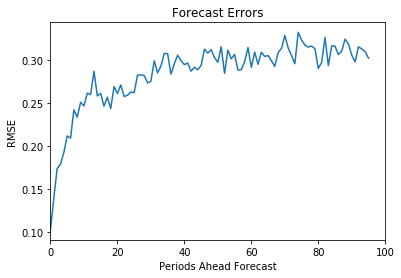

In [71]:
y_pred_test_mor = mor.predict(d2_X_test)
print("The RMSE of the MultiOutput Regressor model on the test set is: ", np.sqrt(mean_squared_error(y_pred_test_mor,y_test )))
mse_test_mor = mean_squared_error(y_pred_test_mor, y_test, multioutput = 'raw_values')
rmse_test_mor = [np.sqrt(x) for x in mse_test_mor]
plt.plot(rmse_test_mor)
plt.title('Forecast Errors')
plt.xlim(0, 100)
plt.ylabel("RMSE")
plt.xlabel("Periods Ahead Forecast")
plt.show()

The tuned model actually performs better on the test set than the multioutput regressor model. Let's see if we can change some of the parameters for better performance.

In [72]:
rfr_tun2 = RandomForestRegressor(n_estimators = 65,criterion = 'mse', min_samples_split = 25, min_samples_leaf = 25, max_depth = 100)
mod_tuned2 = MultiOutputRegressor(rfr_tun2, n_jobs = 2)
mod_tuned2.fit(d2_X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=25, min_samples_split=25,
           min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
           n_jobs=2)

done
done
done
done
done
done


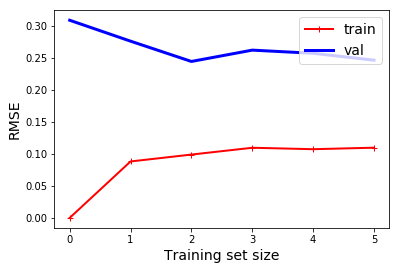

In [73]:
plot_learning_curves(mod_tuned2, d2_X_train, y_train, d2_X_valid, y_valid)

The RMSE looks better this time! Let's check the overall RMSE on all three sets and compare.

In [78]:
y_pred_train_mod_tuned2 = mod_tuned2.predict(d2_X_train)
y_pred_valid_mod_tuned2 = mod_tuned2.predict(d2_X_valid)
print("The RMSE of the tuned model on the training set is ", np.sqrt(mean_squared_error(y_pred_train_mod_tuned2, y_train)), "\n")
print("The RMSE of the tuned model on the validation set is ", np.sqrt(mean_squared_error(y_pred_valid_mod_tuned2, y_valid)), "\n")
y_pred_test_mod_tuned2 = mod_tuned2.predict(d2_X_test)
print("The RMSE of the tuned model on the test set is ", np.sqrt(mean_squared_error(y_pred_test_mod_tuned2, y_test)), "\n")

The RMSE of the tuned model on the training set is  0.1454725331709787 

The RMSE of the tuned model on the validation set is  0.24627682421986388 

The RMSE of the tuned model on the test set is  0.2746548656308782 



So the original tuned model had a better RMSE on training and test sets, So that is the model I will use.